# Parse and Analyze Data

This is where we get the raw nmr data and get it visualized so that it can be fourier transformed

In [1]:
import pandas as pd
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Try reading the ASCII FID file manually
data = np.genfromtxt(r"c:\Users\Windows User\Documents\JEOL\data\13_03_11_indst_1H fid.asc", delimiter='\t', skip_header=1)

# Create a DataFrame with appropriate column names
df = pd.DataFrame(data, columns=['X', 'Real', 'Imaginary'])

# Display the first few rows of the DataFrame
print(df.head())

name = "JEOL data 13_03_11_indst_1H"

          X      Real  Imaginary
0  0.000000  0.000003   0.000009
1  0.000133 -0.001235  -0.003140
2  0.000267  0.050601   0.188029
3  0.000400  0.019175   0.365893
4  0.000533 -0.136525  -0.611649


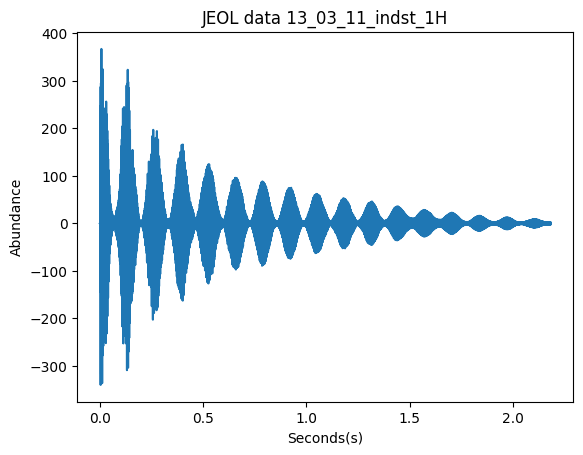

In [3]:
# Ensure data is not None and has valid content
if data is not None and data.size > 0:
	plt.plot(data[:, 0], data[:, 1])  # Assuming the first column is X and the second column is Intensity
	#plt.gca().invert_xaxis()  # Invert x-axis, use after fourier transform
	plt.title(name)
	plt.xlabel("Seconds(s)")
	plt.ylabel("Abundance")
	plt.show()
else:
	print("No valid data found in the file.")


# Fourier Transofrm

Since that the inputted free induction decay (FID) data is a sampled dignal we use the Discrete Fourier Transform. This means using the fft function to get a finite set of frquency components. It is over a finite amount of time (N over a time T, where $N\Delta t = T$). its defined as 

$$\hat{x}(f_n) = \sum_{k=0}^{N-1} x_t e^{-2 \pi i f_n (k \Delta t)} \hspace{10mm} f_n=\frac{n}{N\Delta t}$$

where $f_n$ are the so-called Fourier frequencies. The notation can be simplfied as

When a time series is measured it is discrete and given by $X(t_k)$ where $t_k = k \Delta t$ and $k$ is some integer. If the time series is band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be expressed as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A(f) df$$

where $1/(2\Delta t)$ is the **nyquist frequency** and 

$$\boxed{|A(f)|^2 \equiv S(f)}$$

$S(f)$ is known as the **power spectrum**. It measures the *power* or *amplitude* of a certain frequency present in the continuous time series $X(t)$. If $X(t)$ is real, then $S(f)=S(-f)$, so we only need to consider positive frequencies.


### Note on Nyquist Frequency

If the signal is not band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be written as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A'(f) df$$

where

$$A'(f) = \sum_{k=-\infty}^{\infty} A(f + k/\Delta t) $$

Thus $S'(f) = |A'(f)|^2 \neq S(f)$ and we get power at higher frequencies showing up at lower frequencies. This is known as **aliasing**.

In [4]:
from scipy.fft import fft, fftfreq, fftshift

# Perform Fourier Transform
real_part = data[:, 1]
fft_result = fft(real_part)
frequencies = fftfreq(len(real_part), d=(data[1, 0] - data[0, 0]))  # Calculate frequency axis
fft_magnitude = np.abs(fft_result)

In [5]:
# Keep only the positive half of the spectrum
positive_frequencies = frequencies[frequencies >= 0]
positive_magnitude = fft_magnitude[frequencies >= 0]
# Adjust frequencies by subtracting the x_offset


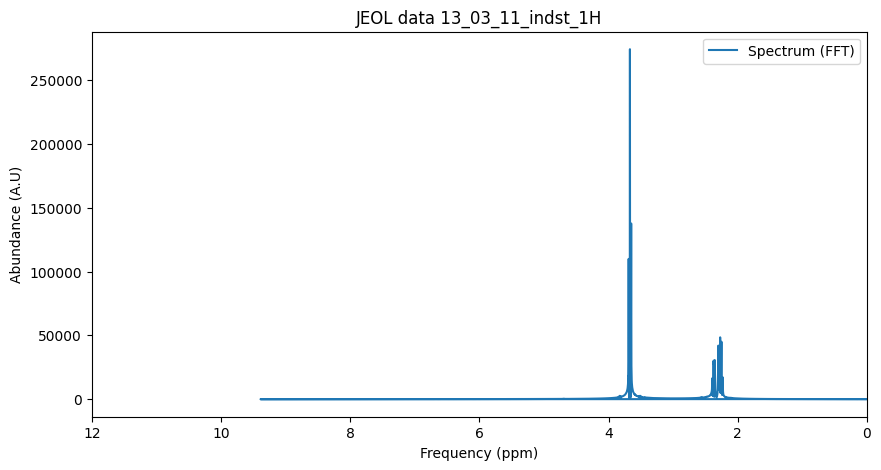

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(positive_frequencies) / 399.5, fftshift(positive_magnitude), label="Spectrum (FFT)")
plt.gca().invert_xaxis()  # Invert the x-axis
plt.title(name)
plt.xlabel("Frequency (ppm)")
plt.ylabel("Abundance (A.U)")
plt.xlim(12, 0)  # Adjust x-axis limits as needed
plt.legend()
plt.show()

In [7]:
from scipy.signal import find_peaks

def identify_functional_groups(positive_frequencies, positive_magnitudes, ppm_shifts):
    """
    Identify functional groups based on peak positions in the spectrum.
    """
    # Find peaks in the spectrum
    peaks, _ = find_peaks(positive_magnitudes, height=0.1 * max(positive_magnitudes))  # Adjust height threshold as needed
    peak_positions = positive_frequencies[peaks]

    # Map peaks to functional groups
    identified_groups = []
    for peak in peak_positions:
        for group, ppm_range in ppm_shifts.items():
            # Parse the ppm range
            ppm_min, ppm_max = map(float, ppm_range.replace("ppm", "").split("-"))
            if ppm_min <= peak <= ppm_max:
                identified_groups.append((peak, group))
                break

    return identified_groups

# Define the ppm shifts for functional groups
ppm_shifts = {
    "Carboxylic acid": "10-12 ppm",
    "Aldehyde": "9-10 ppm",
    "Benzene ring": "6.5-8.5 ppm",
    "Hydrogen on an alkene": "4.5-6.5 ppm",
    "Benzylic carbons": "2-2.5 ppm",
    "CH2 on a halogen": "2.5-4.5 ppm",
    "Methyl ketone": "2-2.5 ppm",
    "CH": "0.9-1.1 ppm",
    "CH2": "1.1-1.4 ppm",
    "CH3": "1.4-1.7 ppm"
}

# Identify functional groups based on the spectrum
identified_groups = identify_functional_groups(
    fftshift(positive_frequencies) / 399.5,  # Convert frequencies to ppm
    fftshift(positive_magnitude),
    ppm_shifts
)

# Print the identified functional groups
if identified_groups:
    print("Identified functional groups:")
    for peak, group in identified_groups:
        print(f"The Peak at {peak:.2f} ppm corresponds to a {group}")
else:
    print("No functional groups identified.")

Identified functional groups:
The Peak at 2.25 ppm corresponds to a Benzylic carbons
The Peak at 2.27 ppm corresponds to a Benzylic carbons
The Peak at 2.28 ppm corresponds to a Benzylic carbons
The Peak at 2.28 ppm corresponds to a Benzylic carbons
The Peak at 2.30 ppm corresponds to a Benzylic carbons
The Peak at 2.30 ppm corresponds to a Benzylic carbons
The Peak at 2.36 ppm corresponds to a Benzylic carbons
The Peak at 2.37 ppm corresponds to a Benzylic carbons
The Peak at 2.38 ppm corresponds to a Benzylic carbons
The Peak at 3.65 ppm corresponds to a CH2 on a halogen
The Peak at 3.67 ppm corresponds to a CH2 on a halogen
The Peak at 3.69 ppm corresponds to a CH2 on a halogen


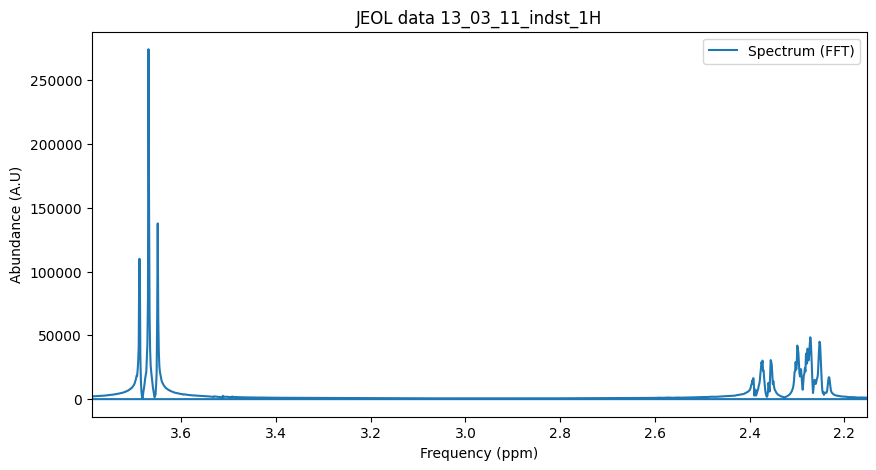

Graph automatically zoomed to range: 2.15 ppm to 3.79 ppm


In [8]:
# Automatically adjust the graph limits based on identified functional groups
if identified_groups:
    # Extract the ppm values of the identified peaks
    peak_ppms = [peak for peak, _ in identified_groups]
    x_min = min(peak_ppms) - 0.1  # Add a small buffer for better visualization
    x_max = max(peak_ppms) + 0.1

    # Plot the spectrum with adjusted x-axis limits
    plt.figure(figsize=(10, 5))
    plt.plot(fftshift(positive_frequencies) / 399.5, fftshift(positive_magnitude), label="Spectrum (FFT)")
    plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(x_max, x_min)  # Set x-axis limits based on identified peaks
    plt.legend()
    plt.show()

    print(f"Graph automatically zoomed to range: {x_min:.2f} ppm to {x_max:.2f} ppm")
else:
    print("No functional groups identified. Default graph will be displayed.")
    # Default graph
    plt.figure(figsize=(10, 5))
    plt.plot(fftshift(positive_frequencies) / 399.5, fftshift(positive_magnitude), label="Spectrum (FFT)")
    plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(name)
    plt.xlabel("Frequency (ppm)")
    plt.ylabel("Abundance (A.U)")
    plt.xlim(x_max, x_min)  # Set x-axis limits based on identified peaks
    plt.legend()
    plt.show()

## * Note for melissa

I am having difficulties here but I think that you might be better able to do it than I can. What I am trying to do here is make it so that the code automatically zooms into whatever peaks are already present on the spectra. Like here for example I want it to make 2 zoomed in graphs that go from like 3.65 to 3.69, and then another graph that goes from 2.25 to 2.38. but I don't want the code to be oriented on those fixed values, but rather I want it to depend on the specific spectrum that the code reads

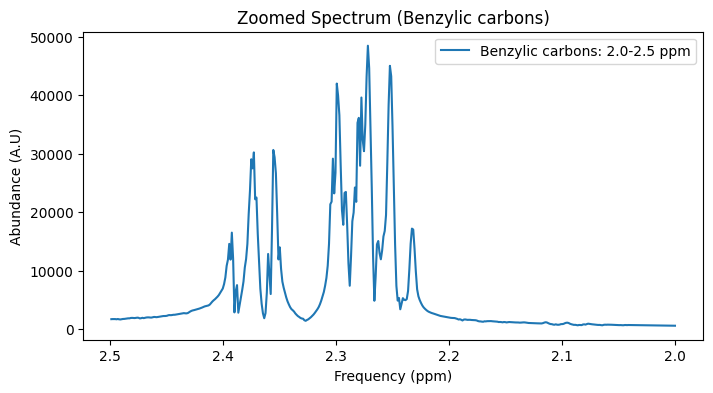

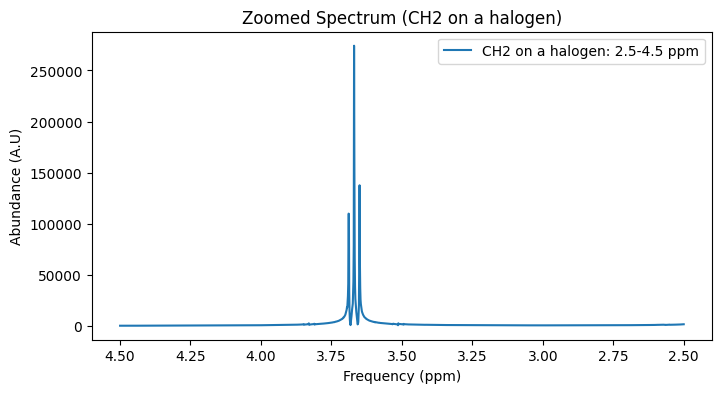

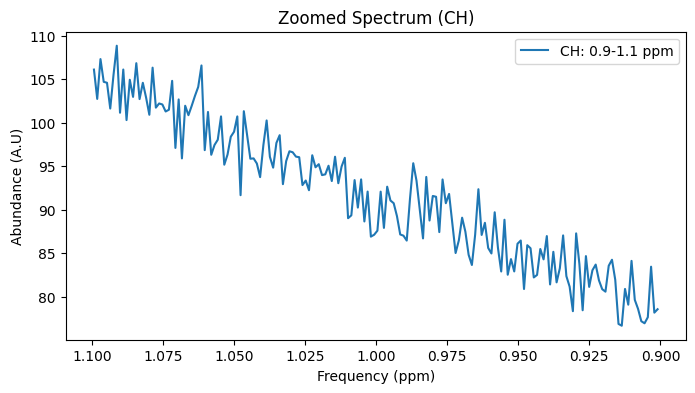

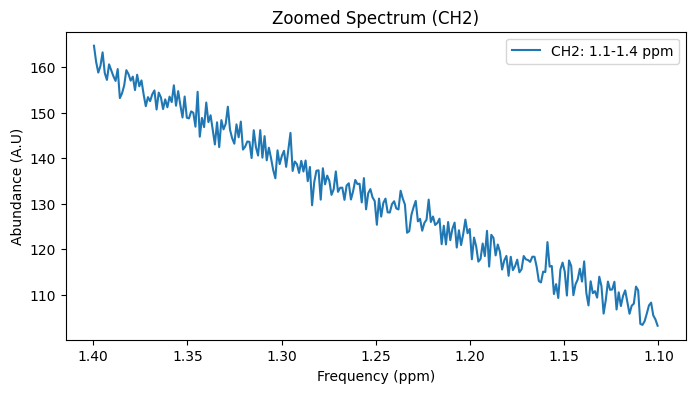

In [9]:
def zoom_into_functional_groups(positive_frequencies, positive_magnitudes, identified_groups, ppm_shifts, title="Zoomed Spectrum"):
    """
    Zoom into specific peaks on the spectrum based on identified functional groups.
    
    Parameters:
    - positive_frequencies: Array of frequencies (ppm).
    - positive_magnitudes: Array of magnitudes (intensity).
    - identified_groups: List of identified functional groups with their peak positions.
    - ppm_shifts: Dictionary of functional groups and their ppm ranges.
    - title: Title of the plot.
    """
    for group, ppm_range in ppm_shifts.items():
        # Parse the ppm range
        ppm_min, ppm_max = map(float, ppm_range.replace("ppm", "").split("-"))
        
        # Check if the functional group is in the identified groups
        if any(group in identified_group for _, identified_group in identified_groups):
            # Filter data within the specified range
            mask = (positive_frequencies / 399.5 >= ppm_min) & (positive_frequencies / 399.5 <= ppm_max)
            zoomed_frequencies = positive_frequencies[mask] / 399.5
            zoomed_magnitudes = positive_magnitudes[mask]
            
            # Plot the zoomed-in region
            plt.figure(figsize=(8, 4))
            plt.plot(zoomed_frequencies, zoomed_magnitudes, label=f"{group}: {ppm_min}-{ppm_max} ppm")
            plt.gca().invert_xaxis()  # Invert the x-axis
            plt.title(f"{title} ({group})")
            plt.xlabel("Frequency (ppm)")
            plt.ylabel("Abundance (A.U)")
            plt.legend()
            plt.show()

# Call the function to zoom into functional groups
zoom_into_functional_groups(
    fftshift(positive_frequencies),
    fftshift(positive_magnitude),
    identified_groups,
    ppm_shifts
)

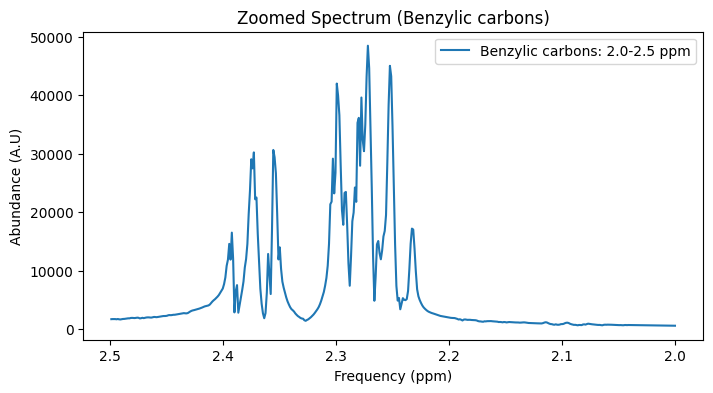

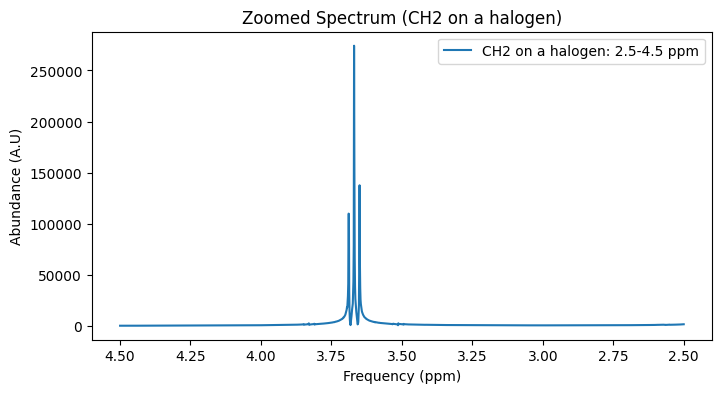

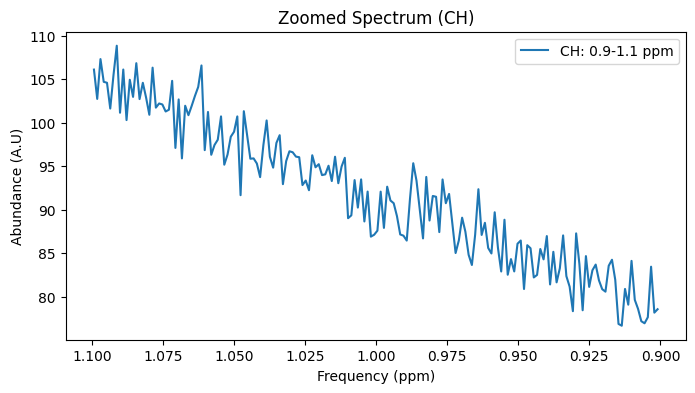

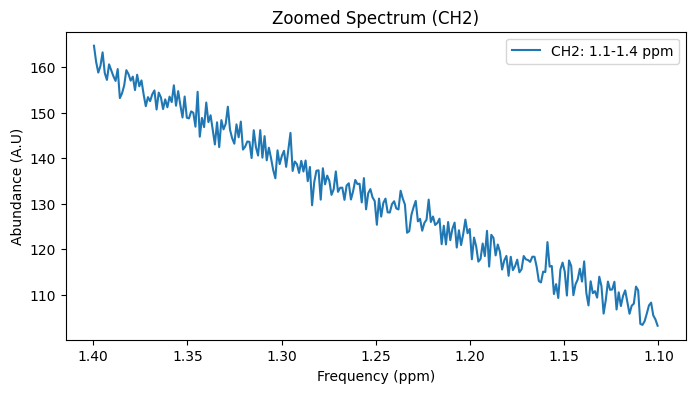

In [10]:
def zoom_into_functional_groups(positive_frequencies, positive_magnitudes, identified_groups, ppm_shifts, title="Zoomed Spectrum"):
    """
    Zoom into specific peaks on the spectrum based on identified functional groups.
    
    Parameters:
    - positive_frequencies: Array of frequencies (ppm).
    - positive_magnitudes: Array of magnitudes (intensity).
    - identified_groups: List of identified functional groups with their peak positions.
    - ppm_shifts: Dictionary of functional groups and their ppm ranges.
    - title: Title of the plot.
    """
    for group, ppm_range in ppm_shifts.items():
        # Parse the ppm range
        ppm_min, ppm_max = map(float, ppm_range.replace("ppm", "").split("-"))
        
        # Check if the functional group is in the identified groups
        if any(group in identified_group for _, identified_group in identified_groups):
            # Filter data within the specified range
            mask = (positive_frequencies / 399.5 >= ppm_min) & (positive_frequencies / 399.5 <= ppm_max)
            zoomed_frequencies = positive_frequencies[mask] / 399.5
            zoomed_magnitudes = positive_magnitudes[mask]
            
            # Plot the zoomed-in region
            plt.figure(figsize=(8, 4))
            plt.plot(zoomed_frequencies, zoomed_magnitudes, label=f"{group}: {ppm_min}-{ppm_max} ppm")
            plt.gca().invert_xaxis()  # Invert the x-axis
            plt.title(f"{title} ({group})")
            plt.xlabel("Frequency (ppm)")
            plt.ylabel("Abundance (A.U)")
            plt.legend()
            plt.show()

# Call the function to zoom into functional groups
zoom_into_functional_groups(
    fftshift(positive_frequencies),
    fftshift(positive_magnitude),
    identified_groups,
    ppm_shifts
)

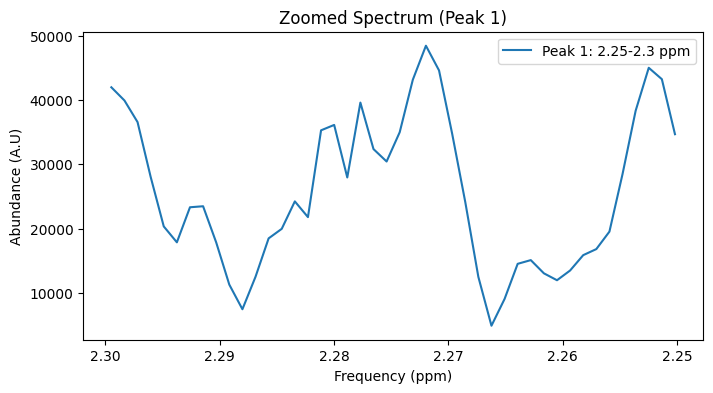

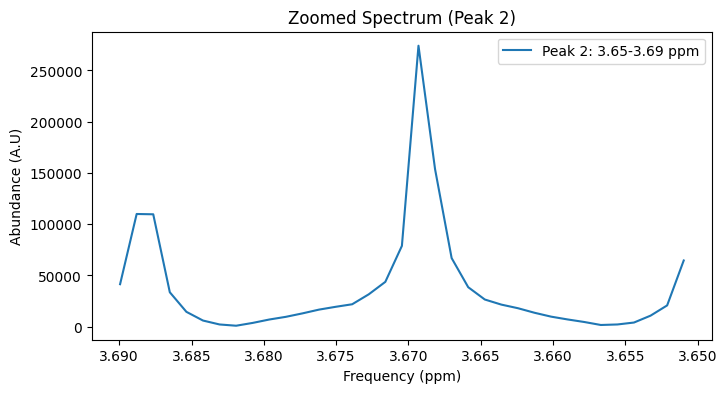

In [11]:
def zoom_into_peaks(positive_frequencies, positive_magnitudes, peak_ranges, title="Zoomed Spectrum"):
    """
    Zoom into specific peaks on the spectrum based on given ranges.
    
    Parameters:
    - positive_frequencies: Array of frequencies (ppm).
    - positive_magnitudes: Array of magnitudes (intensity).
    - peak_ranges: List of tuples specifying the (min, max) ppm ranges to zoom into.
    - title: Title of the plot.
    """
    for i, (ppm_min, ppm_max) in enumerate(peak_ranges):
        # Filter data within the specified range
        mask = (positive_frequencies / 399.5 >= ppm_min) & (positive_frequencies / 399.5 <= ppm_max)
        zoomed_frequencies = positive_frequencies[mask] / 399.5
        zoomed_magnitudes = positive_magnitudes[mask]
        
        # Plot the zoomed-in region
        plt.figure(figsize=(8, 4))
        plt.plot(zoomed_frequencies, zoomed_magnitudes, label=f"Peak {i+1}: {ppm_min}-{ppm_max} ppm")
        plt.gca().invert_xaxis()  # Invert the x-axis
        plt.title(f"{title} (Peak {i+1})")
        plt.xlabel("Frequency (ppm)")
        plt.ylabel("Abundance (A.U)")
        plt.legend()
        plt.show()

# Define the peak ranges to zoom into
peak_ranges = [(2.25, 2.30), (3.65, 3.69)]

# Call the function to zoom into the specified peaks
zoom_into_peaks(fftshift(positive_frequencies), fftshift(positive_magnitude), peak_ranges)

* If its somehow possible to get the functional groups actually on the graph that would be smart....

# Peak integration
The peaks need to be integrated to see how many hydrogens are in each peak.

In [12]:
from scipy.signal import find_peaks
from scipy.integrate import simps

def integrate_peaks(positive_frequencies, positive_magnitudes, peaks):
    """
    Integrate the area under each peak using numerical integration.
    """
    integrated_areas = []
    for peak_idx in peaks:
        # Define a small range around the peak for integration
        left_idx = max(0, peak_idx - 5)  # Adjust range as needed
        right_idx = min(len(positive_frequencies) - 1, peak_idx + 5)
        
        # Extract the frequency and magnitude values around the peak
        freq_range = positive_frequencies[left_idx:right_idx + 1]
        mag_range = positive_magnitudes[left_idx:right_idx + 1]
        
        # Perform numerical integration
        area = simps(mag_range, freq_range)
        integrated_areas.append(area)
    
    return integrated_areas

# Find peaks in the spectrum
peaks, _ = find_peaks(positive_magnitude, height=0.1 * max(positive_magnitude))  # Adjust height threshold as needed

# Integrate the peaks
integrated_areas = integrate_peaks(positive_frequencies, positive_magnitude, peaks)

# Print the results
print("Integrated areas under the peaks:")
for peak_idx, area in zip(peaks, integrated_areas):
    peak_ppm = positive_frequencies[peak_idx] / 399.5  # Convert to ppm
    print(f"Peak at {peak_ppm:.2f} ppm has an integrated area of {area:.2f}")

# Plot the spectrum with annotated peak areas
plt.figure(figsize=(10, 5))
plt.plot(fftshift(positive_frequencies) / 399.5, fftshift(positive_magnitude), label="Spectrum (FFT)")
plt.gca().invert_xaxis()
plt.title(name)
plt.xlabel("Frequency (ppm)")
plt.ylabel("Abundance (A.U)")

# Annotate the peaks with their integrated areas
for peak_idx, area in zip(peaks, integrated_areas):
    peak_ppm = positive_frequencies[peak_idx] / 399.5  # Convert to ppm
    plt.annotate(f"{area:.2f}", (peak_ppm, positive_magnitude[peak_idx]), 
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.legend()
plt.show()

ImportError: cannot import name 'simps' from 'scipy.integrate' (c:\Users\Windows User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\integrate\__init__.py)

## Understanding NMR Spectroscopy: Chemical Shift & Intensity  

### Chemical Shift (δ)  
- **Chemical shift** tells us how **shielded or deshielded** a nucleus is by electrons.  
- The closer a nucleus is to an **electronegative atom**, the more **deshielded** it becomes, moving **downfield (higher ppm)**.  
- The further it is from electronegative atoms, the more **shielded**, moving **upfield (lower ppm)**.  
- Chemical shift is calculated using:  

  $$
  \delta = \frac{\nu_{\text{sample}} - \nu_{\text{reference}}}{\nu_{\text{reference}}} \times 10^6
  $$

  where:  
  - $ \nu_{\text{sample}} $ = Resonance frequency of the sample.  
  - $ \nu_{\text{reference}} $ = Resonance frequency of a reference compound (e.g., **TMS for $ ^1H $-NMR**).  

### Intensity in NMR  
- **Intensity** represents the number of **nuclei absorbing RF energy** at a given frequency.  
- A peak's intensity is **proportional to the number of equivalent nuclei** in that environment.  
- In **$ ^1H $-NMR**, the **area under the peaks (integration)** reveals **relative proton counts**.  
